In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# === 설정 ===
resolution = 100
cell_size = mp.Vector3(1, 1, 0)
fcen = 1.75       # Gaussian source 중심 주파수
df = 3.3          # Gaussian source 대역폭
nfreq = 100

# === 측정할 파장 범위 (0.4 ~ 0.7 μm) ⇒ 주파수로 변환 ===
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max   # ≈ 1.4286
fmax = 1 / lambda_min   # = 2.5
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# === 소스 위치 ===
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ey,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]


In [2]:
# === 경계 (PML) ===
pml_layers = [mp.PML(0.1)]

# === 시뮬레이션 ===
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    default_material=mp.Medium(index=1.0),
    sources=sources,
    resolution=resolution
)

field_component = mp.Ey  # 원하는 필드 성분
offset = 0.01
flux_size = 0.02

# === x1 (왼쪽 세로 라인) ===
x1_dft = sim.add_dft_fields(
    [field_component],
    fcen_dft - df_dft / 2, df_dft, nfreq,
    center=source_center - mp.Vector3(offset, 0, 0),
    size=mp.Vector3(0, flux_size, 0)
)

# === x2 (오른쪽 세로 라인) ===
x2_dft = sim.add_dft_fields(
    [field_component],
    fcen_dft - df_dft / 2, df_dft, nfreq,
    center=source_center + mp.Vector3(offset, 0, 0),
    size=mp.Vector3(0, flux_size, 0)
)

# === y1 (아래쪽 가로 라인) ===
y1_dft = sim.add_dft_fields(
    [field_component],
    fcen_dft - df_dft / 2, df_dft, nfreq,
    center=source_center - mp.Vector3(0, offset, 0),
    size=mp.Vector3(flux_size, 0, 0)
)

# === y2 (위쪽 가로 라인) ===
y2_dft = sim.add_dft_fields(
    [field_component],
    fcen_dft - df_dft / 2, df_dft, nfreq,
    center=source_center + mp.Vector3(0, offset, 0),
    size=mp.Vector3(flux_size, 0, 0)
)


In [3]:
# === 실행 ===
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, source_center, 1e-6))

-----------
Initializing structure...
time for choose_chunkdivision = 7.51019e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.00551391 s
-----------
field decay(t = 50.005): 21454.787092491468 / 21454.787092491468 = 1.0
field decay(t = 100.01): 2.6400756492520434e-07 / 21454.787092491468 = 1.2305298756266804e-11
run 0 finished at t = 100.01 (20002 timesteps)


Text(0, 0.01, 'y2')

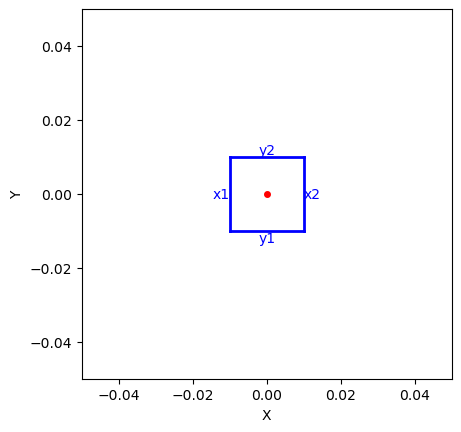

In [4]:
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size = mp.Vector3(0.1,0.1,0))
)

cx, cy = 0, 0
offset = 0.01

# 이름 추가 (텍스트 라벨)
plt.text(cx - offset, cy, "x1", color="blue", fontsize=10, ha='right', va='center')
plt.text(cx + offset, cy, "x2", color="blue", fontsize=10, ha='left', va='center')
plt.text(cx, cy - offset, "y1", color="blue", fontsize=10, ha='center', va='top')
plt.text(cx, cy + offset, "y2", color="blue", fontsize=10, ha='center', va='bottom')

In [5]:
# === 파워 계산 ===
x1_power = [np.sum(np.abs(sim.get_dft_array(x1_dft, field_component, i))**2) for i in range(nfreq)]
x2_power = [np.sum(np.abs(sim.get_dft_array(x2_dft, field_component, i))**2) for i in range(nfreq)]
y1_power = [np.sum(np.abs(sim.get_dft_array(y1_dft, field_component, i))**2) for i in range(nfreq)]
y2_power = [np.sum(np.abs(sim.get_dft_array(y2_dft, field_component, i))**2) for i in range(nfreq)]

# === 총합 power 계산 ===
total_power = np.array(x1_power) + np.array(x2_power) + np.array(y1_power) + np.array(y2_power)

# === 주파수 → 파장 변환 ===
frequencies = np.linspace(fcen_dft - df_dft / 2, fcen_dft + df_dft / 2, nfreq)
wavelengths = 1 / frequencies


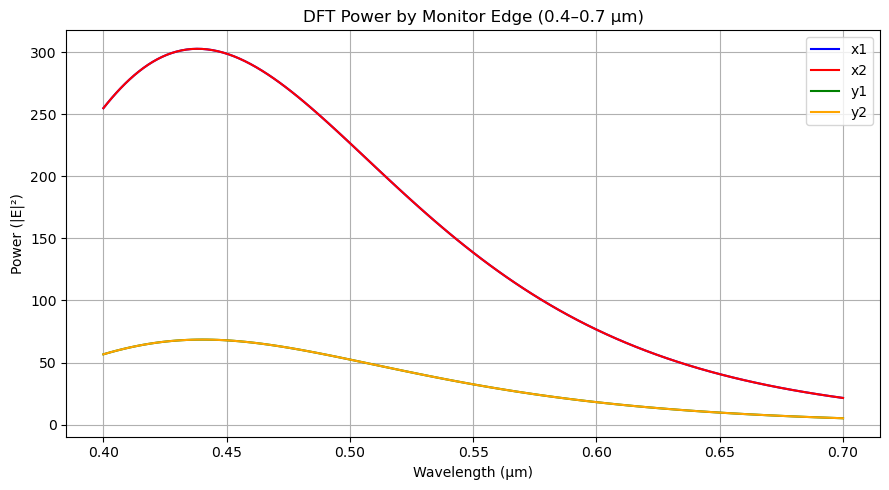

In [6]:
plt.figure(figsize=(9, 5))
plt.plot(wavelengths, x1_power, label='x1', color='blue')
plt.plot(wavelengths, x2_power, label='x2', color='red')
plt.plot(wavelengths, y1_power, label='y1', color='green')
plt.plot(wavelengths, y2_power, label='y2', color='orange')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (|E|²)")
plt.title("DFT Power by Monitor Edge (0.4–0.7 μm)")
# plt.xlim(0.4, 0.7)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


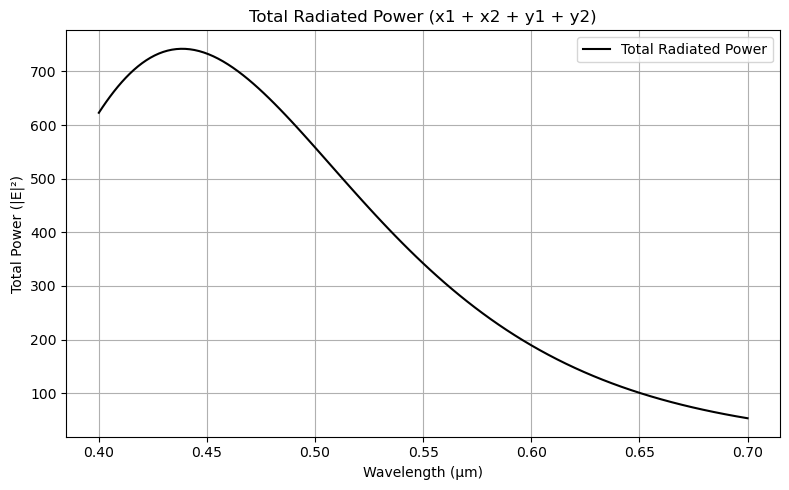

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, total_power, label='Total Radiated Power', color='black')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Total Power (|E|²)")
plt.title("Total Radiated Power (x1 + x2 + y1 + y2)")
# plt.xlim(0.4, 0.7)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
source_flux = sim.add_flux(
    fcen_dft, df_dft, nfreq,
    mp.FluxRegion(center=source_center, size=mp.Vector3(0, 0.02))
)
sim.run(until = 50)
# sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, source_center, 1e-6))
# 1) source 기준 power (단위: W)
source_power = mp.get_fluxes(source_flux)  # shape: (nfreq,)

# 2) 측정된 각 방향 필드의 절대 전력
x1_power = [
    np.sum(np.abs(sim.get_dft_array(x1_dft, field_component, i))**2) / source_power[i]
    for i in range(nfreq)
]
# (x2, y1, y2도 동일하게 정규화)

# 3) 총 전력도 정규화해서 W 단위로 만들 수 있음
total_power = np.array(x1_power) + np.array(x2_power) + np.array(y1_power) + np.array(y2_power)


run 1 finished at t = 150.01500000000001 (30003 timesteps)


# 여기서부터 구분선

In [76]:
sim.reset_meep()

In [77]:
resolution = 100
nfreq = 100

fcen = 1.75
df = 3.3

In [78]:
air_source_center = mp.Vector3(0,0,0)
air_sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ey,
    center=air_source_center,
    size=mp.Vector3(0,0)
)]

resolution_air = 100
sim_air = mp.Simulation(
    cell_size=mp.Vector3(1,1,0),
    default_material=mp.Medium(index=1),
    boundary_layers=pml_layers,
    sources=air_sources,
    resolution=resolution_air
)

-----------
Initializing structure...
time for choose_chunkdivision = 6.79493e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.0054481 s
-----------
field decay(t = 50.005): 21454.787092491468 / 21454.787092491468 = 1.0
field decay(t = 100.01): 2.6400756492520434e-07 / 21454.787092491468 = 1.2305298756266804e-11
run 0 finished at t = 100.01 (20002 timesteps)


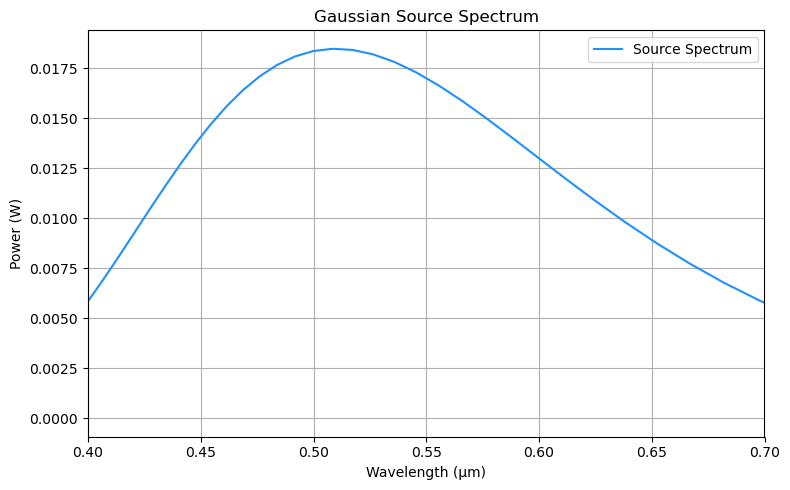

In [43]:
# --- 시뮬레이션 정의 ---
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    default_material=mp.Medium(index=1.0),
    sources=air_sources,
    resolution=resolution
)

# --- 소스 power 측정용 flux monitor 설치 ---
flux_monitor = sim.add_flux(
    fcen, df, nfreq,
    mp.FluxRegion(center=air_source_center + mp.Vector3(0.1, 0, 0), size=mp.Vector3(0, 0.5, 0))
)

# --- 시뮬레이션 실행 ---
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, air_source_center, 1e-6))

# --- 측정된 스펙트럼 가져오기 ---
freqs = mp.get_flux_freqs(flux_monitor)
source_power = mp.get_fluxes(flux_monitor)
wavelengths = 1 / np.array(freqs)

# --- 플롯 ---
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, source_power, label="Source Spectrum", color="dodgerblue")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W)")
plt.title("Gaussian Source Spectrum")
plt.grid(True)
plt.xlim(0.4, 0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
# 박스 4면
offset = 0.01
flux_size = 0.02

fmin = 1 / 0.7     # ≈ 1.4286
fmax = 1 / 0.4     # = 2.5
fcen_focus = 0.5 * (fmin + fmax)
df_focus   = fmax - fmin
nfreq = 300

# 박스 4면
x1_air = sim_air.add_flux(
    fcen_focus, df_focus, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=air_source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

x2_air = sim_air.add_flux(
    fcen_focus, df_focus, nfreq, 
    # flux x2
    mp.FluxRegion(
        center=air_source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
)

y1_air = sim_air.add_flux(
    fcen_focus, df_focus, nfreq, 
    # flux y1
    mp.FluxRegion(
        center=air_source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

y2_air = sim_air.add_flux(
    fcen_focus, df_focus, nfreq, 
    # flux y2
    mp.FluxRegion(
        center=air_source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)



In [81]:
sim_air.run(until=50)

-----------
Initializing structure...
time for choose_chunkdivision = 7.29561e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.00620198 s
-----------
run 0 finished at t = 50.0 (10000 timesteps)


In [87]:
air_x1_data = mp.get_fluxes(x1_air)
air_x2_data = mp.get_fluxes(x2_air)
air_y1_data = mp.get_fluxes(y1_air)
air_y2_data = mp.get_fluxes(y2_air)

frequency_air =  mp.get_flux_freqs(x1_air)
wavelengths_air = 1 / np.array(frequency_air)

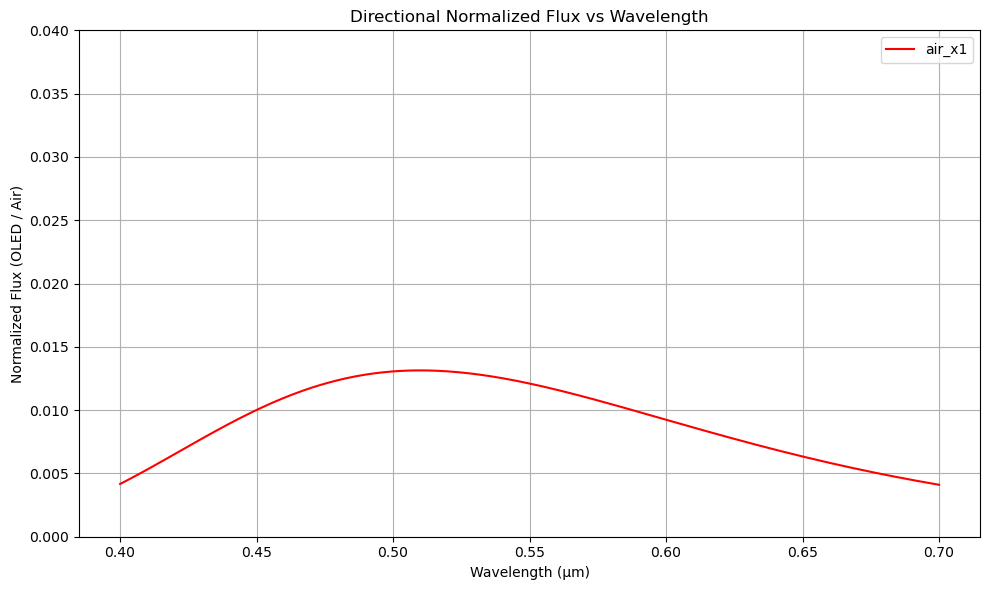

In [97]:
# 정규화된 directional flux 계산
air_x1 = np.array(air_x1_data)
air_x2 = np.array(air_x2_data)

air_y1 = np.array(air_y1_data)
air_y2 = np.array(air_y2_data)

k = air_x1+air_x2+air_y1+air_y2

plt.figure(figsize=(10, 6))
plt.plot(wavelengths_air,air_x1, label='air_x1', color='red')
# plt.plot(wavelengths_air,air_x2, label='air_x2', color='blue')
# plt.plot(wavelengths_air,air_y1, label='air_y1', color='green')
# plt.plot(wavelengths_air,air_y2, label='air_y2', color='black')
# plt.plot(wavelengths_air,k, label='x1+x2+y1+y2', color='magenta')

plt.xlabel("Wavelength (μm)")
plt.ylabel("Normalized Flux (OLED / Air)")
plt.title("Directional Normalized Flux vs Wavelength")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.xlim([0.4, 0.7])
plt.ylim([0,0.04])
plt.show()